## In this notebook: Figs 3D, 3C, 3E, S3

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import matplotlib as mpl
plt.style.use("article.mplstyle")

import mne

from statannotations.Annotator import Annotator
import itertools

import glob
import os
import sys
from scipy.io import savemat, loadmat
from scipy.stats import pearsonr, spearmanr, sem
from statsmodels.stats.multitest import fdrcorrection
import statsmodels.formula.api as smf
import pingouin as pg
import scipy.stats as stats

from mne.stats import permutation_cluster_test, spatio_temporal_cluster_test, combine_adjacency
from mne.stats import permutation_cluster_1samp_test

sys.path.append('/Users/cindyzhang/Documents/Audiomotor_Piano/AM_EEG/utils')
mne.set_log_level('CRITICAL')
import warnings 
warnings.filterwarnings("ignore", category=FutureWarning)

from ERP_utils import *
from update_sub_lists import*
from plot_utils import *
from stats_utils import *

In [61]:
# np.random.seed(42)

#plotting parameters
firsts_color = 'teal'
others_color = 'coral'

axis_fontsize = 20
xtick_fontsize = 15

In [62]:
erp_times = create_erp_times(-0.5,0.5, 128)
ep_path = '../analysis_error/error_epochs_data_n05to05_30Hz_corrected'
mapchange_path = '../analysis_error/mapchange_csv_corrected_since'

#plotting parameters
ch_to_plot = 'Fz' #use Fz for main figs
ch_idx = ch_index([ch_to_plot])

## Prep data

In [63]:
def plot_ci95(distr, bar_ypos, bracketsize = 3, **kwargs):

    ci_l, ci_u = ci95_bs(distr, axis = 0)
    plt.hlines(bar_ypos, ci_l, ci_u, **kwargs)
    plt.vlines(ci_l, bar_ypos - bracketsize, bar_ypos + bracketsize, **kwargs)
    plt.vlines(ci_u, bar_ypos - bracketsize, bar_ypos + bracketsize, **kwargs)
    

def config_bs_plot(bar_ypos, fontsize = 20, **kwargs):
    #plot vertical line at 0
    plt.vlines(0, 0, bar_ypos, **kwargs)

    #plt.legend(fontsize = xtick_fontsize)
    plt.ylim(0, bar_ypos+10)
    plt.xlabel(r'Mean difference ($\mu$V)', fontsize = fontsize)
    plt.ylabel('Frequency', fontsize = fontsize)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))
    plt.yticks([0, 120],fontsize = fontsize*0.7)
    plt.xticks(fontsize = fontsize*0.7)
    plt.xlim(-2.5e-6,1e-6)


def permutation_test_compare(data1, data2, n_permutations=10000):
    """
    Performs a two-sided permutation test comparing the means of two datasets.
    Returns an approximate p-value.
    """
    obs_diff = np.mean(data1) - np.mean(data2)
    combined = np.concatenate([data1, data2])
    n_1 = len(data1)
    perm_diffs = np.zeros(n_permutations)

    for i in range(n_permutations):
        permuted = np.random.permutation(combined)
        perm_data1 = permuted[:n_1]
        perm_data2 = permuted[n_1:]
        perm_diffs[i] = np.mean(perm_data1) - np.mean(perm_data2)

    p_2tail = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))
    return max(p_2tail, 1 / n_permutations)


In [64]:
def load_epochs_df(subjects_to_process, periods):

    eps_df_all = pd.DataFrame()

    for subject in subjects_to_process:
        for period in periods: 

            ep_file = os.path.join(ep_path, f'error_epochs_all_{period}_{subject}.fif')
            #check that the file exists
            if not os.path.isfile(ep_file):
                # print(f"File {ep_file} does not exist, skipping.")
                continue

                #info for each subject and period
            eps_df_sub = {
                'subject': subject,
                'period': period
            }
            eps = mne.read_epochs(ep_file).get_data()

            #read mapchange data
            mapchange_file = os.path.join(mapchange_path, f'mapchange_keystrokes_{period}_{subject}.csv')
            mapchange_df = pd.read_csv(mapchange_file)
            mapchange_df_firsts = mapchange_df.query('type =="first"')
            mapchange_df_others = mapchange_df.query('type =="other"')

            firsts_idx = mapchange_df_firsts['keystroke_idx'].values
            others_idx = mapchange_df_others['keystroke_idx'].values

            try:
                first_eps = eps[firsts_idx]
                eps_df_sub['first_eps'] = [first_eps]
            except IndexError:
                print(f"IndexError for first_eps in subject {subject}, period {period}")

            try:
                other_eps = eps[others_idx]
                # eps_others_all.append(other_eps)
                eps_df_sub['other_eps'] = [other_eps]
            except IndexError:

                print(f"IndexError for other_eps in subject {subject}, period {period}")
                max_idx = eps.shape[0]
                others_idx_crop = [i for i in others_idx if i < max_idx]
                other_eps = eps[others_idx_crop]
                eps_df_sub['other_eps'] = [other_eps]      

            #concatenate to ep df
            eps_df_sub = pd.DataFrame(eps_df_sub)
            eps_df_all= pd.concat([eps_df_all, eps_df_sub], ignore_index=True)

    return eps_df_all

def add_segment_col(mapchange_df, percentile = 60):
    """ 
    Make a new column that segments based on inter-note intervals
    mapchange_df: should have time of the epoch
    interval: a multiple of the mean inter-note interval. Threshold = interval * mean inter-note interval
    """
    df_withsegments = mapchange_df.copy()
    time_diffs = np.insert(np.diff(df_withsegments['time'].values), 0,0)
    df_withsegments['time_diffs'] = time_diffs
    # threshold = interval * np.mean(time_diffs)
    threshold = np.percentile(df_withsegments['time_diffs'], percentile) 
    df_withsegments['segmented'] =  df_withsegments['time_diffs'] > threshold

    return df_withsegments



def load_epochs_df_nothead(subjects_to_process, periods, threshold_percentile):

    eps_df_all = pd.DataFrame()

    for subject in subjects_to_process:
        for period in periods: 

            ep_file = os.path.join(ep_path, f'error_epochs_all_{period}_{subject}.fif')
            #check that the file exists
            if not os.path.isfile(ep_file):
                # print(f"File {ep_file} does not exist, skipping.")
                continue

                #info for each subject and period
            eps_df_sub = {
                'subject': subject,
                'period': period
            }
            eps = mne.read_epochs(ep_file).get_data()

            #read mapchange data
            mapchange_file = os.path.join(mapchange_path, f'mapchange_keystrokes_{period}_{subject}.csv')
            mapchange_df = pd.read_csv(mapchange_file)

            mapchange_df = add_segment_col(mapchange_df, percentile = threshold_percentile) ### ADD SEGMENTS

            mapchange_df_firsts = mapchange_df.query('type =="first" and segmented == False')
            mapchange_df_others = mapchange_df.query('type =="other" and segmented == False')

            firsts_idx = mapchange_df_firsts['keystroke_idx'].values
            others_idx = mapchange_df_others['keystroke_idx'].values

            try:
                first_eps = eps[firsts_idx]
                eps_df_sub['first_eps'] = [first_eps]
            except IndexError:
                print(f"IndexError for first_eps in subject {subject}, period {period}")

            try:
                other_eps = eps[others_idx]
                # eps_others_all.append(other_eps)
                eps_df_sub['other_eps'] = [other_eps]
            except IndexError:

                print(f"IndexError for other_eps in subject {subject}, period {period}")
                max_idx = eps.shape[0]
                others_idx_crop = [i for i in others_idx if i < max_idx]
                other_eps = eps[others_idx_crop]
                eps_df_sub['other_eps'] = [other_eps]      

            #concatenate to ep df
            eps_df_sub = pd.DataFrame(eps_df_sub)
            eps_df_all= pd.concat([eps_df_all, eps_df_sub], ignore_index=True)

    return eps_df_all



In [65]:
#load listen data
subjects_listen = ['22','23','24', '25', '26', '27']
periods_listen = ['13pre', '15pre', '16pre', '17pre', '14pre', '18pre', '19pre', '20pre']
eps_df_listen = load_epochs_df(subjects_listen, periods_listen)

eps_df_listen['first_evs'] = eps_df_listen['first_eps'].apply(lambda x: np.mean(x, axis=0))
eps_df_listen['other_evs'] = eps_df_listen['other_eps'].apply(lambda x: np.mean(x, axis=0))

eps_df_bytype = eps_df_listen.melt(id_vars=['subject', 'period'], value_vars=['first_eps', 'other_eps'], var_name='epochtype', value_name='epochs')
f_df_listen = eps_df_bytype.query('epochtype == "first_eps"')
o_df_listen = eps_df_bytype.query('epochtype == "other_eps"')
o_df_listen = o_df_listen.reset_index(drop = True)

In [66]:
#load playing data
good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()

subjects_playing = good_error_subjects
periods_playing = ['pre']
eps_df_playing = load_epochs_df(subjects_playing, periods_playing)

eps_df_playing['first_evs'] = eps_df_playing['first_eps'].apply(lambda x: np.mean(x, axis=0))
eps_df_playing['other_evs'] = eps_df_playing['other_eps'].apply(lambda x: np.mean(x, axis=0))

eps_df_bytype = eps_df_playing.melt(id_vars=['subject', 'period'], value_vars=['first_eps', 'other_eps'], var_name='epochtype', value_name='epochs')
f_df_play= eps_df_bytype.query('epochtype == "first_eps"')
o_df_play = eps_df_bytype.query('epochtype == "other_eps"')
o_df_play = o_df_play.reset_index(drop = True)

## Fig 3D: Difference waves

In [67]:
#find difference waves
eps_df_playing['diff_evs'] = eps_df_playing['first_evs'] - eps_df_playing['other_evs']
eps_df_listen['diff_evs'] = eps_df_listen['first_evs'] - eps_df_listen['other_evs']

#isolate difference waves over channels
diff_p_erp_ch = np.array(eps_df_playing['diff_evs'].tolist())[:, ch_idx, :].squeeze()
diff_l_erp_ch = np.array(eps_df_listen['diff_evs'].tolist())[:, ch_idx, :].squeeze()

#mean and sem over subjects for plotting
diff_p_erp_ch_mean = np.mean(diff_p_erp_ch, axis = 0).flatten()
diff_l_erp_ch_mean = np.mean(diff_l_erp_ch, axis = 0).flatten()
diff_p_erp_ch_sem = sem(diff_p_erp_ch, axis = 0).flatten()
diff_l_erp_ch_sem = sem(diff_l_erp_ch, axis = 0).flatten()

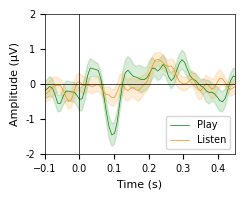

In [68]:
fig = plt.figure(figsize=(1.9,1.4))
ax = fig.add_axes([0,0,1,1])

plot_mean_sem(erp_times, diff_p_erp_ch_mean, diff_p_erp_ch_sem, color = 'green', label = 'Play', linewidth=0.5)
plot_mean_sem(erp_times, diff_l_erp_ch_mean, diff_l_erp_ch_sem, color = 'darkorange', label = 'Listen', linewidth =0.5)


#permutation test to find timepoints of interest
colours = ['green', 'darkorange']
for i,diff_array in enumerate([diff_p_erp_ch, diff_l_erp_ch]):
# for i, diff_array in enumerate([diff_p_erp_ch, diff_l_erp_ch]):
    # run a one‐sample cluster‐based permutation test on the difference
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    diff_array,
    n_permutations=1000,
    tail=0,            # two‐sided by default; use tail=1 or -1 for one‐sided
    out_type="mask"
    )

    sig_idxs = np.where(cluster_p_values < 0.05)[0]  # Get indices of all significant clusters

    for sig_idx in sig_idxs:
        time_slice = clusters[sig_idx][0]  # Get the time slice object
        start, stop, step = time_slice.start, time_slice.stop, time_slice.step or 1
        plt.hlines(1e-6, erp_times[start], erp_times[stop], color = colours[i], linewidth = 2)

# config_erp_plot(axis_fontsize=None, tick_fontsize=None, linewidth=0.5)
# Add labels, legend, and grid
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
# plt.title(f'ERP first and others, {period} training {ch_to_plot}')
plt.hlines(0, -0.5, 0.5, color = 'black')
plt.vlines(0, -6.5e-6, 6e-6, color = 'black')

plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert to µV
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 1e6)}'))  # Convert to µV as integer

plt.xlim(-0.1, 0.45)
plt.legend(loc = 'lower right')
plt.ylim(-2e-6, 2e-6)
plt.savefig(f'./figures/erp_diff_{ch_to_plot}.svg', transparent=True)

## Figure 3C: bootstrap n100, Figure S3 bootstrap other time points and channels

In [69]:
#bootstrap parameters
time_to_plot = 0.1
time_idx = time_index_custom([time_to_plot], erp_times)[0]

n_iterations = 10 #1000
n_samples = 100

#plotting parameters
n_bins = 25


#### listening

In [ ]:
# #listening 

#find boostrapped means
bs_distr_listen = bootstrap_diffs(f_df_listen, o_df_listen, time_idx, n_iter = n_iterations, n_samp = n_samples)
bs_distr_listen_null = bootstrap_diffs(o_df_listen, o_df_listen,time_idx, n_iter = n_iterations, n_samp = n_samples)

#find CI95 of bootstrapped distribution
ci_l_listen, ci_u_listen = ci95_bs(bs_distr_listen, axis = 0)
ci_l_listen_null, ci_u_listen_null = ci95_bs(bs_distr_listen_null, axis = 0)

# #plot bootstrap
plt.figure(figsize=(10,3))

ch_to_plot = 'Fz'
ch_idx = ch_index([ch_to_plot])
#plot hist
counts_firsts, _, _= plt.hist(bs_distr_listen[:, ch_idx], bins = n_bins, color = 'darkorange', label = 'firsts vs others', alpha = 0.5)
counts_others, _, _ = plt.hist(bs_distr_listen_null[:, ch_idx], bins = n_bins, color = 'black', label = 'others vs others', alpha = 0.5)
bar_ypos = max(np.max(counts_firsts), np.max(counts_others))

#plot CI95
plot_ci95(bs_distr_listen[:, ch_idx], bar_ypos = bar_ypos, color = 'darkorange', linewidth = 2, alpha = 0.5)
plot_ci95(bs_distr_listen_null[:, ch_idx], bar_ypos = bar_ypos, color = 'black', linewidth = 2, alpha = 0.5)
config_bs_plot(bar_ypos, color = 'red', linestyles = '--')

plt.title(f'LISTEN firsts and others diff {time_to_plot}s, {ch_to_plot}, {n_samples} samples, {n_iterations} bootstrap iters')
# plt.savefig(f'./figs/bootstrap_fo_{ch_to_plot}_{time_to_plot}_listen.svg')

Text(0.5, 1.0, 'PLAY firsts and others diff 0.1s, Fz, 100 samples, 10 bootstrap iters')

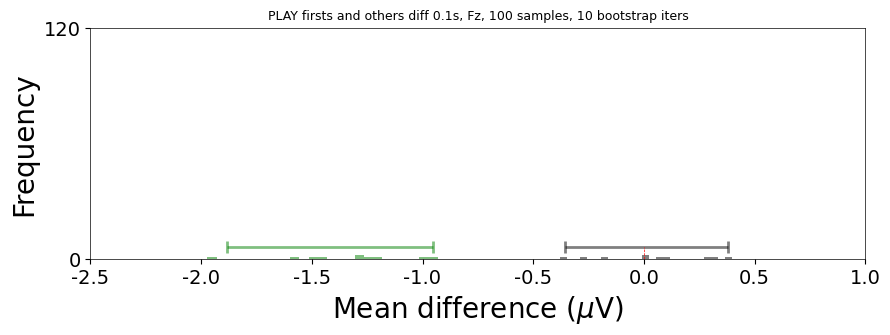

In [76]:
# #playing 

#find boostrapped means
bs_distr_play = bootstrap_diffs(f_df_play, o_df_play, time_idx, n_iter = n_iterations, n_samp = n_samples)
bs_distr_play_null = bootstrap_diffs(o_df_play, o_df_play,time_idx, n_iter = n_iterations, n_samp = n_samples)

#find CI95 of bootstrapped distribution
ci_l_play, ci_u_play = ci95_bs(bs_distr_play, axis = 0)
ci_l_play_null, ci_u_play_null = ci95_bs(bs_distr_play_null, axis = 0)

# #plot bootstrap
plt.figure(figsize=(10,3))

#plot hist
counts_firsts, _, _= plt.hist(bs_distr_play[:, ch_idx], bins = n_bins, color = 'green', label = 'firsts vs others', alpha = 0.5)
counts_others, _, _ = plt.hist(bs_distr_play_null[:, ch_idx], bins = n_bins, color = 'black', label = 'others vs others', alpha = 0.5)

#plot CI95
bar_ypos = max(np.max(counts_firsts), np.max(counts_others)) + 4 #position of the top of the bars
plot_ci95(bs_distr_play[:, ch_idx], bar_ypos = bar_ypos, color = 'green', linewidth = 2, alpha = 0.5)
plot_ci95(bs_distr_play_null[:, ch_idx], bar_ypos = bar_ypos, color = 'black', linewidth = 2, alpha = 0.5)
config_bs_plot(bar_ypos, color = 'red', linestyles = '--')


plt.title(f'PLAY firsts and others diff {time_to_plot}s, {ch_to_plot}, {n_samples} samples, {n_iterations} bootstrap iters')
# plt.savefig(f'./figs/bootstrap_fo_{ch_to_plot}_{time_to_plot}_play.svg')

## stats

In [72]:
# STATS
#USE THE CHANNEL DATA
bs_distr_play_ch = bs_distr_play[:, ch_idx].flatten()
bs_distr_listen_ch = bs_distr_listen[:, ch_idx].flatten()
bs_distr_play_null_ch = bs_distr_play_null[:, ch_idx].flatten()
bs_distr_listen_null_ch = bs_distr_listen_null[:, ch_idx].flatten()

# is f-o in playing different from 0
obs_diff_play = np.mean(bs_distr_play_ch)
p_play_2tail = 2 * min(
    np.mean(bs_distr_play_null_ch >= obs_diff_play),
    np.mean(bs_distr_play_null_ch <= obs_diff_play)
)
print('p-value playing vs null', p_play_2tail)

#is f-o in listening different from 0
#2-tail emperical p-value
obs_diff_listen = np.mean(bs_distr_listen_ch)
p_listen_2tail = 2 * min(
    np.mean(bs_distr_listen_null_ch >= obs_diff_listen),
    np.mean(bs_distr_listen_null_ch <= obs_diff_listen)
)
print('p-value listening', p_listen_2tail)

#are playing and listening different
obs_diff = np.mean(bs_distr_play) - np.mean(bs_distr_listen)
combined = np.concatenate([bs_distr_play, bs_distr_listen])
n_play = len(bs_distr_play)

 #run permutation
n_permutations = 10000
perm_diffs = np.zeros(n_permutations)

for i in range(n_permutations):
    np.random.shuffle(combined)
    perm_play = combined[:n_play]
    perm_listen = combined[n_play:]
    perm_diffs[i] = np.mean(perm_play) - np.mean(perm_listen)

# #two-tailed p-value
# p_compare_2tail = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))
p_compare_2tail = permutation_test_compare(bs_distr_play_ch, bs_distr_listen_ch, n_permutations=10000)
print('p_value play vs listen', p_compare_2tail)

p-value playing vs null 0.0
p-value listening 0.2
p_value play vs listen 0.0001


In [73]:
#set up dataframe for barplot
#take absolute difference and mean across selected channels
fo_bs = pd.DataFrame({
    'listen': np.mean(bs_distr_listen[:, ch_idx], axis = 1),
    'playing': np.mean(bs_distr_play[:, ch_idx], axis = 1),
    'null': np.mean(bs_distr_play_null[:, ch_idx], axis = 1)
})

fo_bs_sns = pd.melt(fo_bs, var_name = 'condition', value_name = 'fo_diff')

## Fig 3E: bootstrapped f-o differences listen vs play

In [74]:
# stats for permjutaiton test
obs_diff = np.mean(bs_distr_play) - np.mean(bs_distr_listen)

# combine the two distributions
combined = np.concatenate([bs_distr_play, bs_distr_listen])
n_play = len(bs_distr_play)

# run the permutation test
n_permutations = 10000
perm_diffs = np.zeros(n_permutations)

for i in range(n_permutations):
    np.random.shuffle(combined)
    perm_play = combined[:n_play]
    perm_listen = combined[n_play:]
    perm_diffs[i] = np.mean(perm_play) - np.mean(perm_listen)

# two-tailed p-value
p_val = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))

print(f"Observed mean difference: {obs_diff:.10f}")
print(f"Permutation test p-value (2-tailed): {p_val:.10f}")


Observed mean difference: -0.0000006461
Permutation test p-value (2-tailed): 0.0000000000


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

playing vs. null: Custom statistical test, P_val:0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

listen vs. null: Custom statistical test, P_val:2.000e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

listen vs. playing: Custom statistical test, P_val:1.000e-04


/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


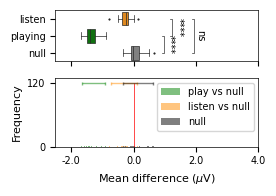

In [75]:
fig, axs = plt.subplots(2, 1, figsize=(2.8, 2), sharex=True, gridspec_kw={'height_ratios':[0.6,0.8]})
palette = {'playing': 'green', 'listen': 'darkorange', 'null': 'grey'}

# ===== Horizontal Boxplot =====
ax = axs[0]
sns.boxplot(
    data=fo_bs_sns,
    y='condition',
    x='fo_diff',
    palette=palette,
    ax=ax,
    flierprops=dict(
        marker='o',
        markersize=mpl.rcParams['lines.markersize']*0.5,
        markeredgewidth=mpl.rcParams['lines.linewidth']
    )
)

# Stat annotations
pairs_list = [
    (('playing', 'null'), p_play_2tail),
    (('listen', 'null'), p_listen_2tail),
    (('listen', 'playing'), p_compare_2tail)
]

line_offsets = [0.1, 0.4, 0.25]

for (pairs, pval), offset in zip(pairs_list, line_offsets):
    annot = Annotator(ax, [pairs], data=fo_bs_sns, y='condition', x='fo_diff', orient='h')
    annot.set_pvalues([pval])
    annot.configure(loc='inside', fontsize=mpl.rcParams['xtick.labelsize'], line_width=mpl.rcParams['lines.linewidth'])
    annot.annotate(line_offset_to_group=offset)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(-2.5e-6, 4e-6)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*1e6:.1f}'))  # Convert to µV

# ===== Histogram =====
ax = axs[1]
counts_play, _, _ = ax.hist(bs_distr_play[:, ch_idx], bins=n_bins, alpha=0.5, label='play vs null', color='green')
counts_listen, _, _ = ax.hist(bs_distr_listen[:, ch_idx], bins=n_bins, alpha=0.5, label='listen vs null', color='darkorange')
counts_null, _, _ = ax.hist(bs_distr_play_null[:, ch_idx], bins=n_bins, alpha=0.5, label='null', color='black')

ax.legend(loc='upper right')
bar_ypos = 120
ax.vlines(0, 0, bar_ypos, color='red')
ax.set_ylim(0, bar_ypos + 10)
ax.set_ylabel('Frequency')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*1e6:.1f}'))  # Convert to µV
ax.set_xlim(-2.5e-6, 4e-6)
ax.set_yticks([0, 120])

# Plot CI95
plot_ci95(bs_distr_play[:, ch_idx], bar_ypos=bar_ypos, color='green', linewidth=1, alpha=0.5)
plot_ci95(bs_distr_listen[:, ch_idx], bar_ypos=bar_ypos, color='darkorange', linewidth=1, alpha=0.5)
plot_ci95(bs_distr_play_null[:, ch_idx], bar_ypos=bar_ypos, color='black', linewidth=1, alpha=0.5)

plt.xlabel(r'Mean difference ($\mu$V)')
plt.tight_layout()
plt.savefig(f'./figures/playlisten_combined_{ch_to_plot}.svg', transparent=True, bbox_inches='tight')
